In [1]:
pip install mesa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.5/226.5 kB 2.7 MB/s eta 0:00:00


In [2]:
pip install -U mesa[rec]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 425.7/425.7 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.2/168.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.4/263.4 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.1 MB/s eta 0:00:00


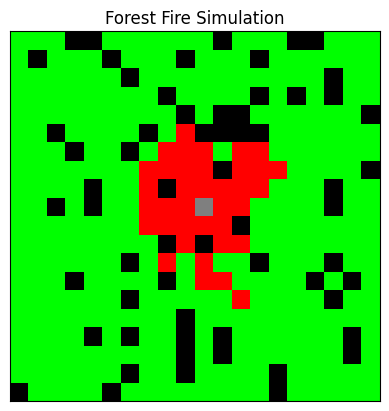

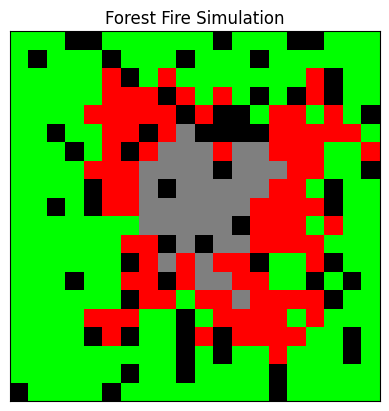

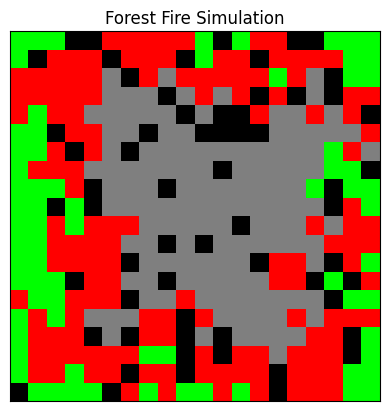

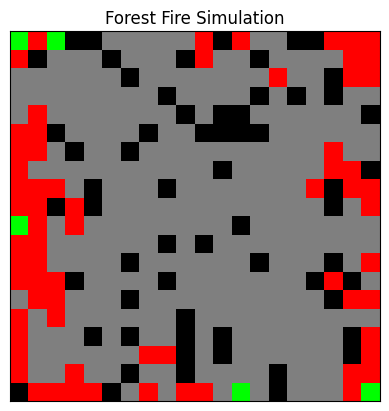

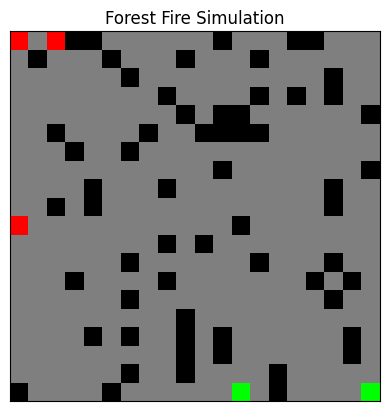

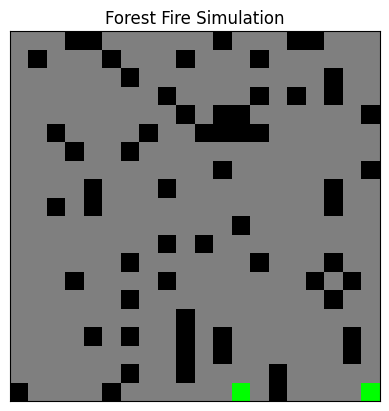

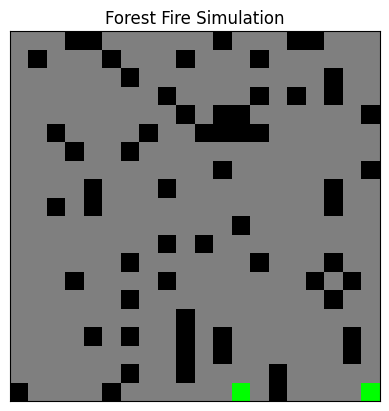

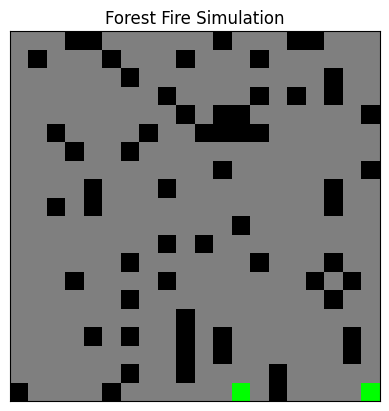

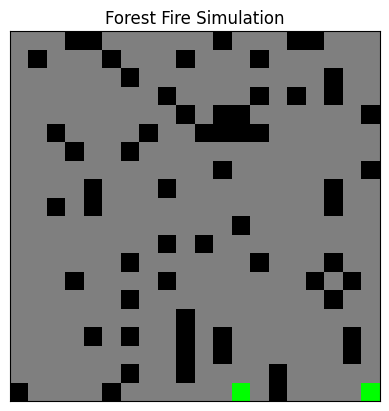

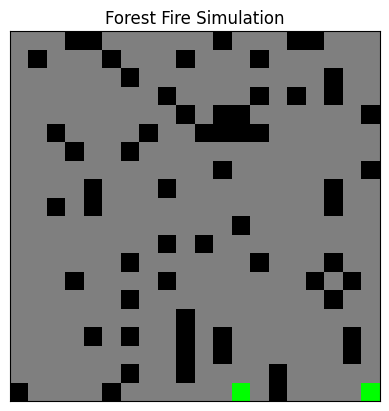

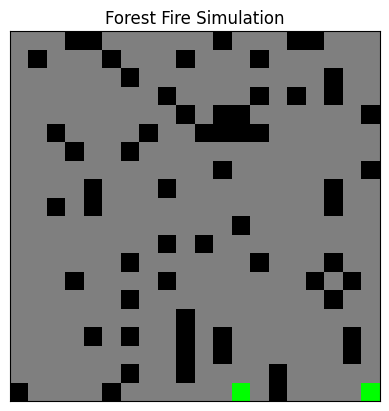

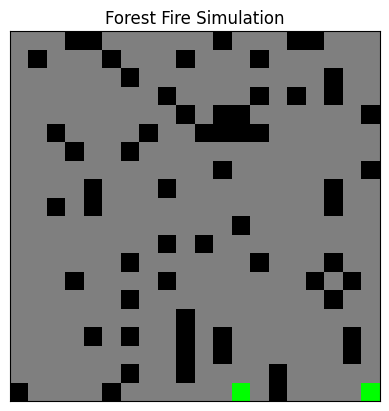

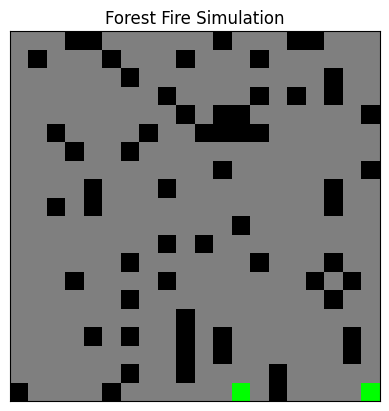

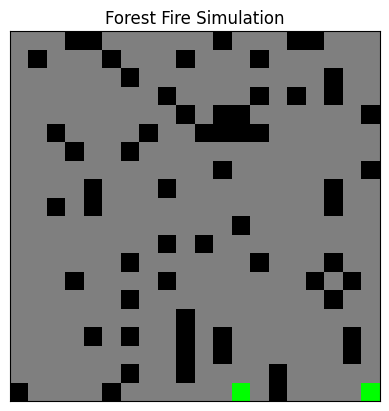

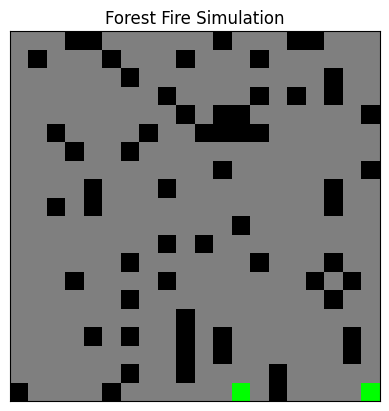

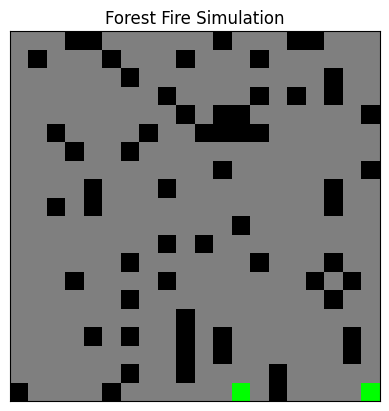

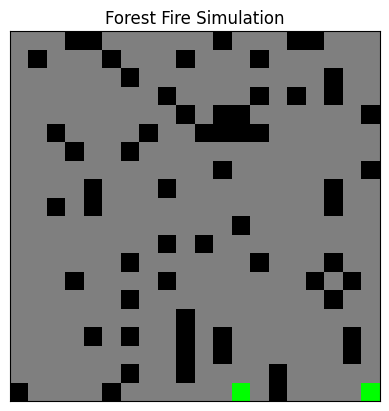

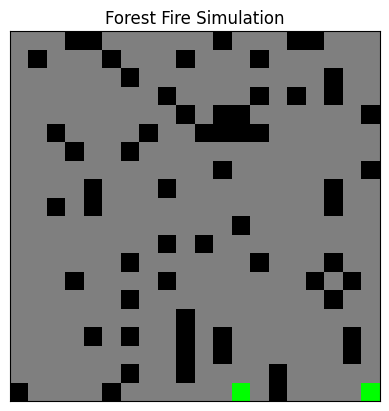

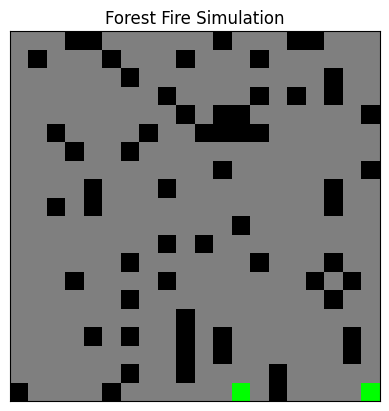

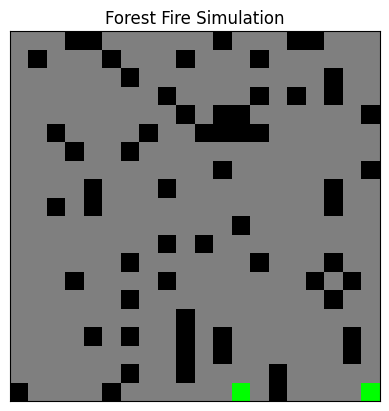

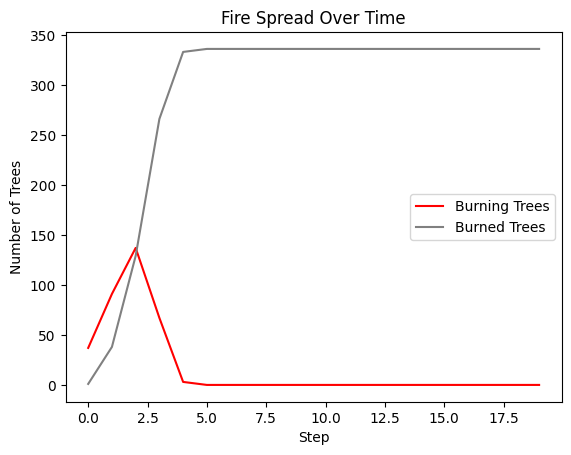

In [3]:
import time  # For adding a delay between steps

from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import matplotlib.pyplot as plt
import numpy as np

# Define the Tree agent class
class Tree(Agent):
    def __init__(self, model):
        super().__init__(model)  # Unique ID is automatically managed by Mesa
        self.state = "Alive"  # Initial state of the tree

    def step(self):
        if self.state == "Burning":
            # If the tree is burning, it will become burned in the next step
            self.state = "Burned"
        elif self.state == "Alive":
            # Check neighbors for any burning trees
            neighbors = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
            for neighbor in neighbors:
                if isinstance(neighbor, Tree) and neighbor.state == "Burning":
                    # If a neighbor is burning, this tree catches fire
                    self.state = "Burning"
                    break

# Define the ForestFireModel class
class ForestFireModel(Model):
    def __init__(self, width, height, density, seed=None):
        super().__init__(seed=seed)  # Calling super to initialize Mesa Model properly
        self.grid = MultiGrid(width, height, torus=False)

        # Populate the grid with trees based on density
        for content, (x, y) in self.grid.coord_iter():
            if self.random.random() < density:
                tree = Tree(self)
                self.grid.place_agent(tree, (x, y))

        # Start the fire with a single tree in the middle
        center_x, center_y = width // 2, height // 2
        center_tree = self.grid.get_cell_list_contents((center_x, center_y))
        if center_tree:
            center_tree[0].state = "Burning"

        # Initialize data collection
        self.datacollector = DataCollector(
            model_reporters={
                "Burning Trees": self.count_burning_trees,
                "Burned Trees": self.count_burned_trees
            }
        )

    def step(self):
        # Activate all agents' step function in a shuffled order
        self.agents.shuffle_do("step")  # Using AgentSet for agent activation
        self.datacollector.collect(self)  # Collect data each step

    def count_burning_trees(self):
        # Count and return burning trees
        return sum(1 for agent in self.agents if isinstance(agent, Tree) and agent.state == "Burning")

    def count_burned_trees(self):
        # Count and return burned trees
        return sum(1 for agent in self.agents if isinstance(agent, Tree) and agent.state == "Burned")

# Visualization function for the forest grid at each step
def plot_forest(model):
    width, height = model.grid.width, model.grid.height
    grid = np.zeros((width, height, 3))  # Create a 3D array for RGB colors

    for x in range(width):
        for y in range(height):
            cell = model.grid.get_cell_list_contents((x, y))
            if cell:
                tree = cell[0]
                if tree.state == "Alive":
                    grid[x, y] = [0, 1, 0]  # Green for alive
                elif tree.state == "Burning":
                    grid[x, y] = [1, 0, 0]  # Red for burning
                elif tree.state == "Burned":
                    grid[x, y] = [0.5, 0.5, 0.5]  # Gray for burned

    # Plot the forest grid with colors for each tree state
    plt.imshow(grid, origin="lower")
    plt.title("Forest Fire Simulation")
    plt.xticks([]), plt.yticks([])
    plt.show()
    plt.pause(0.5)  # Pause to visualize each step for 0.5 seconds

# Function to run the model with step-by-step visualization
def run_model_with_visualization(width, height, density, steps):
    model = ForestFireModel(width, height, density)
    plt.ion()  # Turn on interactive mode for live updating
    for _ in range(steps):
        model.step()
        plot_forest(model)  # Plot the forest after each step
        time.sleep(0.5)  # Add delay to slow down each step for visualization
    plt.ioff()  # Turn off interactive mode
    return model  # Return the model to access the collected data

# Visualization function for fire spread over time
def plot_fire_spread(model):
    data = model.datacollector.get_model_vars_dataframe()
    plt.plot(data["Burning Trees"], label="Burning Trees", color="red")
    plt.plot(data["Burned Trees"], label="Burned Trees", color="gray")
    plt.xlabel("Step")
    plt.ylabel("Number of Trees")
    plt.legend()
    plt.title("Fire Spread Over Time")
    plt.show()

# Model parameters
width, height = 20, 20  # Grid size
density = 0.8           # Probability of a tree being present in each cell
steps = 20              # Number of steps to simulate

# Run the model with step-by-step visualization
model = run_model_with_visualization(width, height, density, steps)

# Plot the fire spread over time using the collected data from the model
plot_fire_spread(model)